## 이미지 로드

### Subtask:
분석할 이미지를 로드합니다.


**Reasoning**:
Load the image file using OpenCV and print a message indicating success or failure.



In [2]:
import cv2
import numpy as np

image_path = '/content/drive/MyDrive/deepfashion2/deepfashion2/test/test/image/000120.jpg'

# 이미지를 로드합니다. (Load the image)
image = cv2.imread(image_path)

# 이미지 로드 성공 또는 실패를 확인하고 메시지를 출력합니다. (Check for successful image loading and print a message)
if image is None:
    print(f"Error: Could not load image from {image_path}")
else:
    print(f"Image loaded successfully from {image_path}")

# 이미지 해상도를 1/4로 줄입니다. (Reduce image resolution to 1/4)
# 인터폴레이션 방법은 필요에 따라 변경 가능합니다. (Interpolation method can be changed as needed)
new_width = int(image.shape[1] / 2)
new_height = int(image.shape[0] / 2)
image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

# 이미지를 BGR에서 RGB로 변환합니다. (Convert image from BGR to RGB)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Image loaded successfully from /content/drive/MyDrive/deepfashion2/deepfashion2/test/test/image/000120.jpg


**Reasoning**:
The previous attempt to load the image failed. I will try loading a sample image provided by scikit-learn as a fallback. I will then convert it to BGR color space to be compatible with OpenCV and confirm the image loading.



## 색상 추출

### Subtask:
이미지에서 픽셀별 색상 데이터를 추출합니다.


**Reasoning**:
Extract the pixel color data from the loaded image by reshaping it into a list of pixels.



In [3]:
# 이미지의 높이와 너비를 가져옵니다. (Get the height and width of the image)
height, width, _ = image.shape

# 이미지 데이터를 픽셀 리스트 형태로 재구성합니다. 각 행은 하나의 픽셀입니다. (Reshape the image data into a 2D array where each row is a pixel)
pixel_colors = image.reshape((-1, 3))

# 추출된 픽셀 색상의 형태를 출력합니다. (Print the shape of the extracted pixel colors)
print(f"Shape of extracted pixel colors: {pixel_colors.shape}")

Shape of extracted pixel colors: (73008, 3)


## 색 공간 변환

### Subtask:
추출된 색상 데이터를 RGB에서 HSV 색 공간으로 변환합니다. 채도(Saturation)와 명도(Value) 정보를 모두 사용합니다.


**Reasoning**:
Convert the pixel color data from BGR to RGB and then to HSV color space and print the shape as requested by the instructions.



In [4]:
# BGR에서 HSV로 직접 변환합니다. (Convert BGR to HSV directly)
# OpenCV에서는 HSV 이미지를 H(0~180), S(0~255), V(0~255)로 표현
pixel_colors_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
pixel_colors_hsv = pixel_colors_hsv.reshape((-1, 3))

# 변환된 HSV 픽셀 색상의 형태를 출력합니다. (Display the shape of the converted HSV pixel colors)
print(f"Shape of HSV pixel colors: {pixel_colors_hsv.shape}")

Shape of HSV pixel colors: (73008, 3)


## 데이터 준비

### Subtask:
클러스터링을 위해 채도와 명도 데이터를 결합합니다.


**Reasoning**:
Extract the saturation and value channels from the HSV pixel data and combine them into a single array for clustering.



In [5]:
# 채도 값을 추출합니다. (Extract the saturation values)
saturation_values = pixel_colors_hsv[:, 1]

# 명도 값을 추출합니다. (Extract the value values)
# 명도를 사용할지 논의 필요
# value_values = pixel_colors_hsv[:, 2]

# 클러스터링을 위해 채도 값만 사용합니다. (Use only saturation values for clustering)
# saturation_value_data = np.vstack((saturation_values, value_values)).T
saturation_value_data = saturation_values.reshape(-1, 1)


# 결합된 데이터의 형태를 출력합니다. (Display the shape of the combined data)
print(f"Shape of saturation data for clustering: {saturation_value_data.shape}")

Shape of saturation data for clustering: (73008, 1)


## 클러스터링 (dbscan)

### Subtask:
HSV 색상 데이터의 채도와 명도 값을 사용하여 DBSCAN 클러스터링을 수행합니다.


**Reasoning**:
Import DBSCAN, instantiate it with initial parameters, fit the model to the saturation and value data, and then print the number of clusters and noise points.



In [25]:
from sklearn.cluster import DBSCAN

# eps는 두 샘플 사이의 최대 거리로, 한 샘플이 다른 샘플의 이웃으로 간주되는 기준
# min_samples는 한 점이 핵심 점(core point)으로 간주되기 위한 이웃의 샘플 수
dbscan = DBSCAN(
    eps=0.5,
    min_samples=5000)

# DBSCAN 모델을 채도 데이터에 맞춥니다. (Fit the DBSCAN model to the saturation data)
dbscan.fit(saturation_value_data)

# 클러스터 레이블을 가져옵니다. (Get the cluster labels)
labels = dbscan.labels_

# 잡음(-1 레이블)을 제외한 클러스터 수를 계산합니다. (Number of clusters in labels, ignoring noise if present.)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# 잡음 점의 수를 계산합니다. (Count the number of noise points.)
n_noise_ = list(labels).count(-1)

# 추정된 클러스터 수와 잡음 점 수를 출력합니다. (Print the estimated number of clusters and noise points.)
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

Estimated number of clusters: 2
Estimated number of noise points: 52541


## 클러스터 분석

### Subtask:
각 클러스터의 평균 채도와 명도 또는 분포를 분석합니다.


**Reasoning**:
Create a pandas DataFrame from the saturation and value data and the cluster labels, filter out noise points, group by cluster, calculate the mean saturation and value for each cluster, and print the results.



In [29]:
import pandas as pd

# DataFrame을 생성합니다. (Create a DataFrame)
df_clusters = pd.DataFrame({
    'saturation': saturation_value_data[:, 0] if saturation_value_data.ndim > 1 else saturation_value_data.flatten(),  # 채도 데이터 (Saturation data)
    # 'value': saturation_value_data[:, 1],       # 명도 데이터 (Value data)
    'cluster': labels                          # 클러스터 레이블 (Cluster labels)
})

# 잡음 점(레이블 -1)을 필터링합니다. (Filter out noise points (label -1))
df_filtered = df_clusters[df_clusters['cluster'] != -1].copy()

# 클러스터별로 그룹화하고 각 클러스터의 평균 채도를 계산합니다. (Group by cluster and calculate mean saturation for each cluster)
mean_saturation_per_cluster = df_filtered.groupby('cluster')[['saturation']].mean()

# 각 클러스터의 평균 채도를 출력합니다. (Print the mean saturation for each cluster)
print("Mean Saturation per Cluster:")
print(mean_saturation_per_cluster)

Mean Saturation per Cluster:
         saturation
cluster            
0               0.0
1              12.0


## 화려함/단조로움 벡터화

### Subtask:
분석된 채도와 명도 정보를 기반으로 이미지의 화려함/단조로움을 나타내는 -1부터 1까지의 벡터 값을 계산합니다. (예: 높은 평균 채도와 명도는 화려함에 가깝게, 낮은 평균 채도와 명도는 단조로움에 가깝게 매핑)


**Reasoning**:
Calculate the vibrancy score based on the mean saturation and value of the identified clusters, excluding noise, as instructed.



In [28]:
# 잡음 점(-1 레이블)을 제외한 픽셀들의 채도 값을 가져옵니다. (Get the saturation values for pixels excluding noise points (label -1))
filtered_saturation_values = df_filtered['saturation']

# 필터링된 픽셀들 중에서 최대 채도 값을 찾습니다. (Find the maximum saturation value among the filtered pixels)
max_overall_saturation = filtered_saturation_values.max()

# 최대 채도 값을 -1과 1 사이의 값으로 정규화합니다. (최대 채도는 255로 가정) (Normalize the maximum saturation value to a value between -1 and 1 (assuming max saturation is 255))
# 값이 0이면 -1, 255이면 1, 중간 값은 선형적으로 매핑됩니다. (If the value is 0, it's -1, if it's 255, it's 1, and values in between are mapped linearly.)
vibrancy_score = (max_overall_saturation / 255.0) * 2 - 1

# 계산된 화려함 점수를 출력합니다. (Print the calculated vibrancy score)
print(f"Maximum overall saturation (0-255): {max_overall_saturation}")
print(f"Calculated Vibrancy Score (-1 to 1): {vibrancy_score}")

Maximum overall saturation (0-255): 29
Calculated Vibrancy Score (-1 to 1): -0.7725490196078432


## 클러스터링 결과 시각화

### Subtask:
DBSCAN 클러스터링 결과를 시각화합니다. 각 픽셀을 해당 클러스터 레이블에 따라 색칠하고, 잡음은 특정 색상으로 표시합니다.

**Reasoning**:
Generate a new image where each pixel's color represents its assigned cluster label from the DBSCAN analysis. Assign a distinct color to each cluster and a specific color for noise points. Reshape the resulting pixel array back to the original image dimensions and display the image.

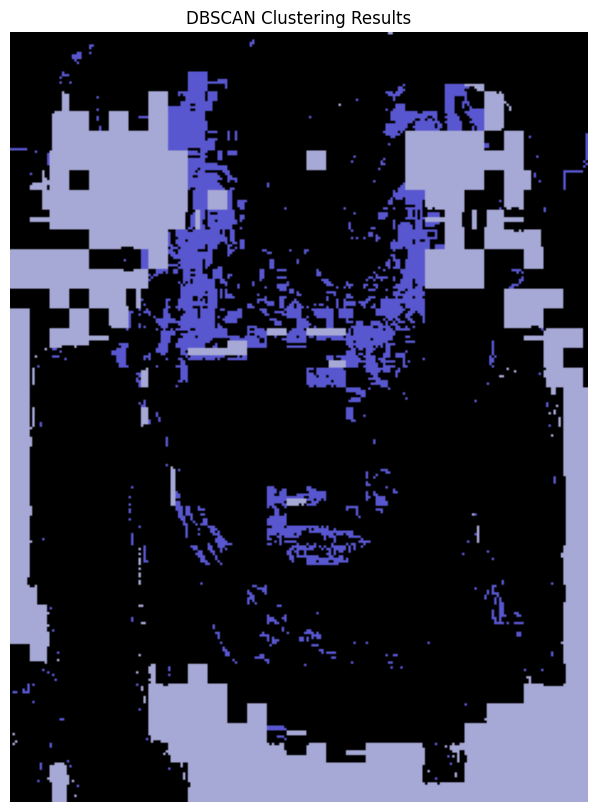

In [30]:
import matplotlib.pyplot as plt
import random

# 클러스터 개수 (잡음 제외)를 가져옵니다. (Get the number of clusters (excluding noise))
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# 각 클러스터에 할당할 임의의 색상을 생성합니다. (Generate random colors for each cluster)
# 색상 값은 0-255 범위의 BGR 형식입니다. (Color values are in BGR format, range 0-255)
cluster_colors = {i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in range(n_clusters)}

# 잡음 점(-1 레이블)에 할당할 색상을 설정합니다 (예: 검은색). (Set the color for noise points (label -1), e.g., black)
noise_color = (0, 0, 0) # BGR 형식의 검은색 (Black in BGR format)

# 클러스터링 결과를 시각화할 빈 이미지 배열을 생성합니다. (Create an empty image array to visualize the clustering results)
# 원본 이미지와 동일한 크기 및 채널 수를 가집니다. (It will have the same dimensions and number of channels as the original image.)
clustered_image_array = np.zeros_like(image)

# 원본 이미지의 픽셀을 반복하면서 해당 클러스터 레이블에 따라 색상을 할당합니다. (Iterate through the pixels of the original image and assign colors based on their cluster labels)
for i in range(height):
    for j in range(width):
        # 해당 픽셀의 인덱스를 계산합니다. (Calculate the index of the current pixel)
        pixel_index = i * width + j
        # 해당 픽셀의 클러스터 레이블을 가져옵니다. (Get the cluster label for the current pixel)
        cluster_label = labels[pixel_index]

        # 레이블에 따라 색상을 할당합니다. (Assign color based on the label)
        if cluster_label == -1:
            # 잡음 점인 경우 잡음 색상을 할당합니다. (If it's a noise point, assign the noise color)
            clustered_image_array[i, j] = noise_color
        else:
            # 클러스터에 속하는 경우 해당 클러스터 색상을 할당합니다. (If it belongs to a cluster, assign the corresponding cluster color)
            clustered_image_array[i, j] = cluster_colors[cluster_label]

# 시각화된 이미지를 표시합니다. (Display the visualized image)
# OpenCV 이미지는 BGR 형식이므로, matplotlib으로 표시하기 위해 RGB로 변환해야 합니다. (OpenCV images are in BGR format, so we need to convert to RGB for displaying with matplotlib.)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(clustered_image_array, cv2.COLOR_BGR2RGB))
plt.title('DBSCAN Clustering Results')
plt.axis('off') # 축 정보를 숨깁니다. (Hide axis information)
plt.show()